### CO2 Emission Prediction.
Data can be obtained [here](https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64).

In [54]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

In [55]:
df = pd.read_csv('data/co2_emission.csv')
df.head()

,model year,make,model,vehicle class,engine size (l),cylinders,transmission,fuel type,fuel consumption city (l/100 km),fuel consumption hwy (l/100 km),fuel consumption comb (l/100 km),fuel consumption comb (mpg),co2 emissions (g/km),co2 rating,smog rating
0,2022,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,200,6,3
1,2022,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,5
2,2022,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,6
3,2022,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,Z,11.3,9.1,10.3,27,242,5,6
4,2022,Acura,TLX SH-AWD,Compact,2.0,4,AS10,Z,11.2,8.0,9.8,29,230,5,7


In [56]:
print("Number of samples: %.0f" % df.shape[0])
print("Number of features: %.0f" % df.shape[1])

Number of samples: 5003
Number of features: 15


## Data Validation
### Missing Values
Let's begin by checking for missing values:

In [57]:
df.isnull().sum()

model year                          0
make                                0
model                               0
vehicle class                       0
engine size (l)                     0
cylinders                           0
transmission                        0
fuel type                           0
fuel consumption city (l/100 km)    0
fuel consumption hwy (l/100 km)     0
fuel consumption comb (l/100 km)    0
fuel consumption comb (mpg)         0
co2 emissions (g/km)                0
co2 rating                          0
smog rating                         0
dtype: int64

The dataset does not have any missing values.

Following the information on the website, the ``co2 rating`` and the ``smog rating`` features are ratings given to a car after the `co2 emission` is known. Thus, this information cannot be included in our model, as we would like to create a model capable of predicting the CO2 emission of a car based on its features. We are going to remove the ``co2 rating`` and the ``smog rating`` from our analysis.

In [58]:
del df['co2 rating']
del df['smog rating']

Now, let's look at the column types:

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5003 entries, 0 to 5002
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   model year                        5003 non-null   int64  
 1   make                              5003 non-null   object 
 2   model                             5003 non-null   object 
 3   vehicle class                     5003 non-null   object 
 4   engine size (l)                   5003 non-null   float64
 5   cylinders                         5003 non-null   int64  
 6   transmission                      5003 non-null   object 
 7   fuel type                         5003 non-null   object 
 8   fuel consumption city (l/100 km)  5003 non-null   float64
 9   fuel consumption hwy (l/100 km)   5003 non-null   float64
 10  fuel consumption comb (l/100 km)  5003 non-null   float64
 11  fuel consumption comb (mpg)       5003 non-null   int64  
 12  co2 em

The `model year` and `cylinder` columns have the `int64` dtype. Let's look at their unique values:

In [60]:
df['model year'].unique()

array([2022, 2021, 2020, 2019, 2018])

In [61]:
df['cylinders'].unique()

array([ 4,  6,  8, 12, 10, 16,  3,  5])

This is actually a categorical column, as these years have discrete values. Let's change the column dtype:

In [9]:
df['model year'] = df['model year'].astype(str)
df['cylinders'] = df['cylinders'].astype(str)

In [10]:
cat_cols = list(df.loc[:, df.dtypes == object].columns)
num_cols = list(df.loc[:, df.dtypes != object].columns)

## Exploratory Data Analysis
Beforing exploring the data, we are going to split the data into train/test/validation sets, with a 60/20/20% ratio.

In [11]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

## Categorical features

Now, let's look at how many unique values the categorical columns have:

In [12]:
df_train_full[cat_cols].nunique()

model year          5
make               39
model            1326
vehicle class      15
cylinders           8
transmission       26
fuel type           4
dtype: int64

Let's analyze each feature individually.
### Model Year

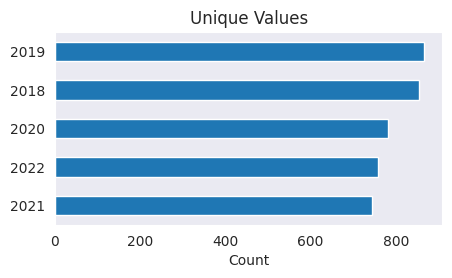

In [13]:
plt.figure(figsize=(5,2.5))
df_train_full['model year'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values')
plt.xlabel('Count')
plt.show()

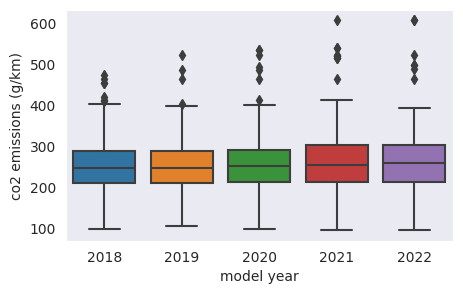

In [14]:
plt.figure(figsize=(5,3))
sns.boxplot(x='model year', 
            y='co2 emissions (g/km)', 
            data=df_train_full.sort_values(by='model year'))
plt.show()

We can see that the CO2 emission has sligthly increased ove the years (which is worrisome, by the way). 

#### Make
The make column contains information about the car manufacturer.

Unique values in the make column:  39


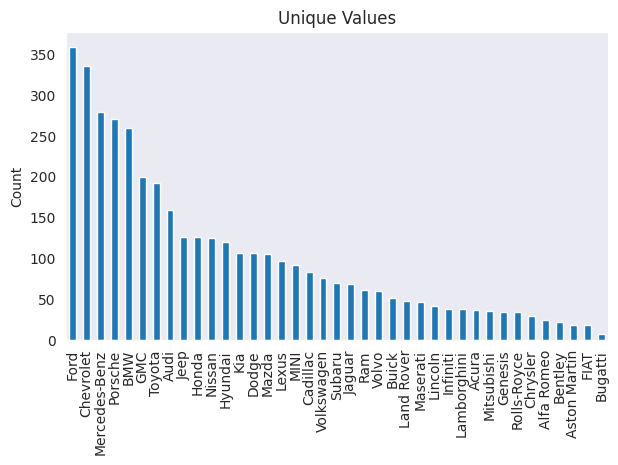

In [15]:
print("Unique values in the make column: ", df_train_full['make'].nunique())
plt.figure(figsize=(7,4))
df_train_full['make'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Unique Values')
plt.ylabel('Count')
plt.show()

Ford, Chevrolet, Mercedes-Benz, Porsche and BMW are the top 5 manufacturers. Manufacturer's of luxury cars, such as Lamborghini, Rolls-Royce and Bugatti, have very few samples.

Let's see how is the CO2 emission distribution among the manufacturers.

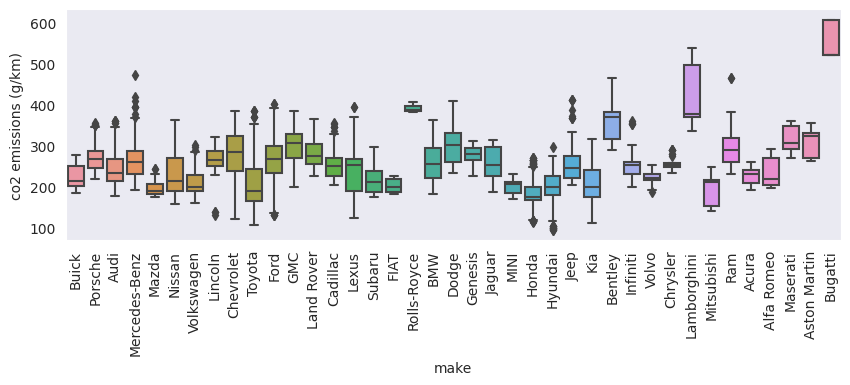

In [16]:
plt.figure(figsize=(10,3))
ax = sns.boxplot(x='make', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The manufacturers present very different distributions of co2 emission. This will be a important feature for our predictions.

Here we can observe some trends:
- Among the cars with the lowest emissions, we find Mazda, Nissan, Toyota, Subaru, Honda and Mitsubishi: all of them are japanese companies. 
- The highest emissions come from manufacturers that produce luxury cars: Rolls-Royce, Bentley, Lamborghini and Bugatti.

### Vehicle Class
Here we have information about the vehicle size (Small, mid-size, compact, etc) and its type (SUV, Pickup truck, van, etc).

Unique values in the vehicle class column:  15


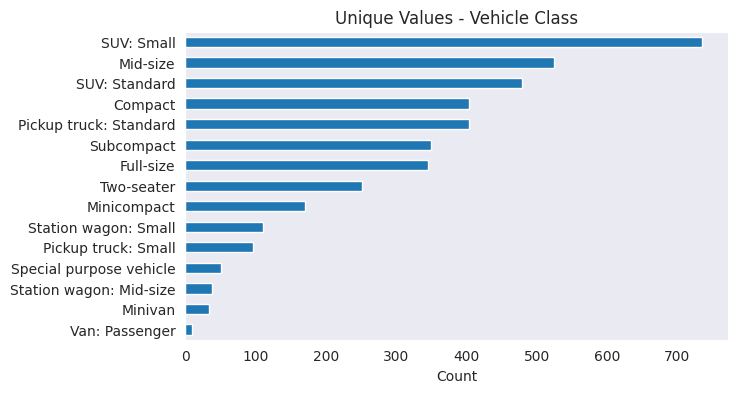

In [17]:
print("Unique values in the vehicle class column: ", df_train_full['vehicle class'].nunique())
plt.figure(figsize=(7,4))
df_train_full['vehicle class'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values - Vehicle Class')
plt.xlabel('Count')
plt.show()

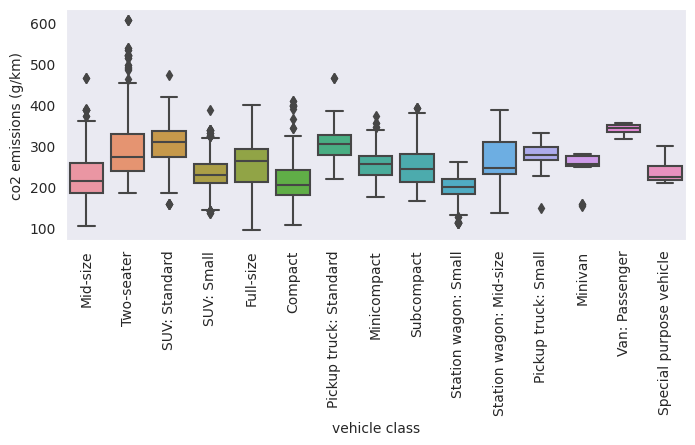

In [18]:
plt.figure(figsize=(8,3))
ax = sns.boxplot(x='vehicle class', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The compact cars are among those that have the lowest C02 emission rates.

### Cylinders

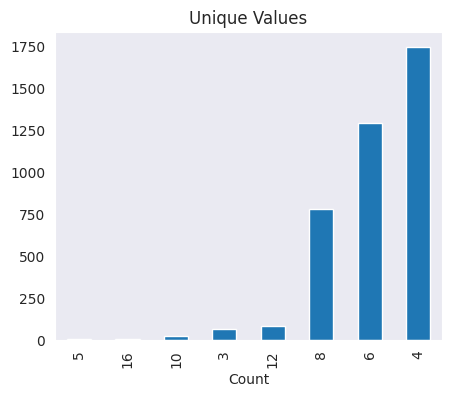

In [19]:
plt.figure(figsize=(5,4))
df_train_full['cylinders'].value_counts().sort_values().plot(kind='bar')
plt.title('Unique Values')
plt.xlabel('Count')
plt.show()

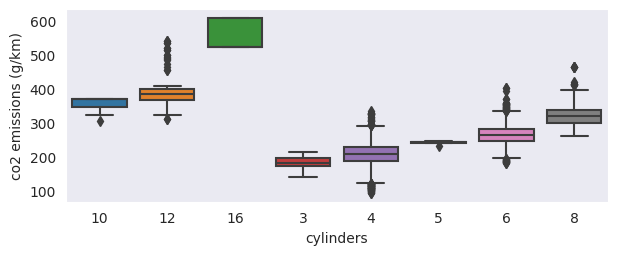

In [20]:
plt.figure(figsize=(7, 2.5))
ax = sns.boxplot(x='cylinders',
                 y='co2 emissions (g/km)', 
                 data=df_train_full.sort_values(by="cylinders"))
plt.show()

Clearly, the CO2 emission rating increases with the cylinders. Thus, this is a very important feature to the model.

### Fuel Type
The fuel type is classified as:

- D = diesel
- E = ethanol (E85)
- X = regular gasoline
- Z = premium gasoline

Unique values in the fuel type column:  4


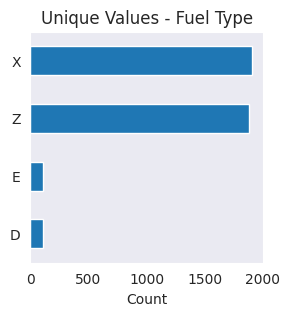

In [21]:
print("Unique values in the fuel type column: ", df_train_full['fuel type'].nunique())
plt.figure(figsize=(3,3))
df_train_full['fuel type'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values - Fuel Type')
plt.xlabel('Count')
plt.show()

Most of the cars run by gasoline, with a minority of the running by ethanol and diesel.

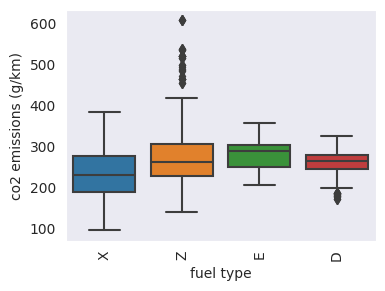

In [22]:
plt.figure(figsize=(4,3))
ax = sns.boxplot(x='fuel type', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

Ethanol and diesel cars have consistently high CO2 emission rates, above 200 g/km for more than 95% of the cars. Cars that run by gasoline present some of the highest emission rates, but also some of the lowest.  
### Transmission
The Transmission is classified as:

- A = automatic
- AM = automated manual
- AS = automatic with select shift
- AV = continuously variable
- M = manual

Unique values in the transmission column:  26


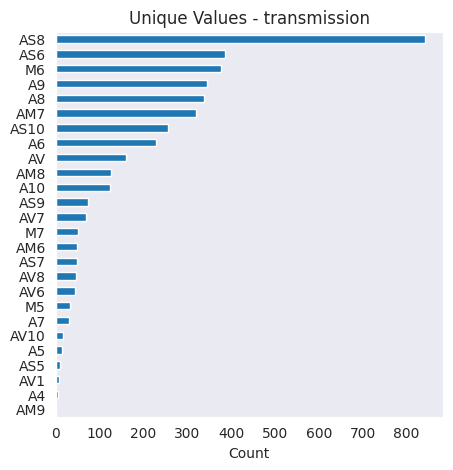

In [64]:
print("Unique values in the transmission column: ", df_train_full['transmission'].nunique())
plt.figure(figsize=(5,5))
df_train_full['transmission'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values - transmission')
plt.xlabel('Count')
plt.show()

Most cars have automatic transmissions, with the automatic select shift (AS) being the most frequent. However, the M6 ​​transmission is the third most frequent, showing that manual cars still have a large share of the market. 

Let's check the CO2 emission for the transmissions:

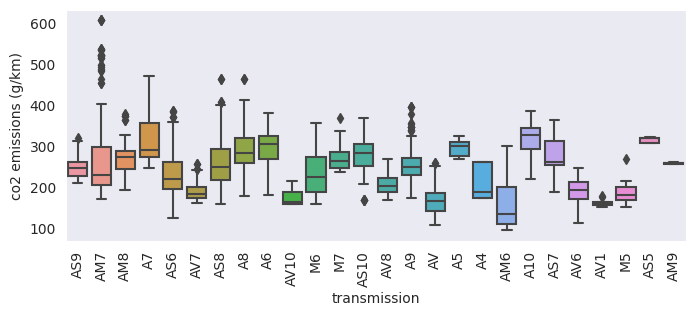

In [77]:
plt.figure(figsize=(8,3))
ax = sns.boxplot(x='transmission', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The highest emissions are among the fully automatic cars (A). The continuously variable (AV) have the lowest CO2 emission ratios. For manual cars, the M5 transmission have low emission rate, whereas the M7 shows high rate and the M6 has a high variance between its samples.

### Model
The model column has many unique values:

In [79]:
df_train_full['model'].nunique()

1326

This column contains 1326 unique values. 

Unique values in the model column:  1326


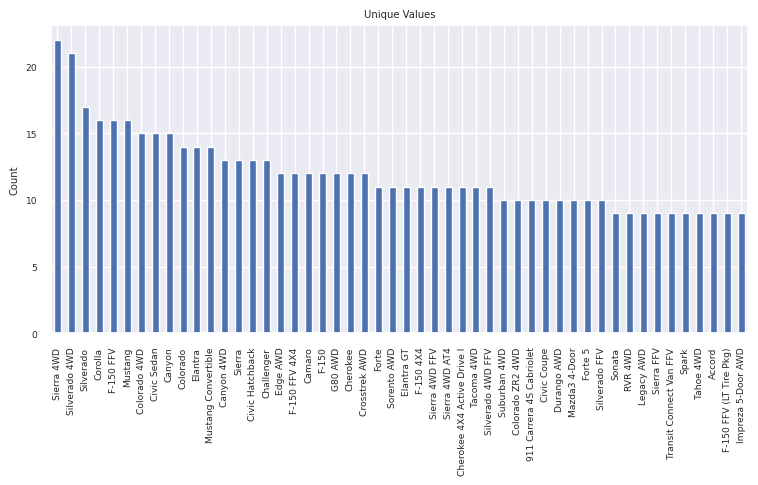

In [234]:
print("Unique values in the model column: ", df_train_full['model'].nunique())
plt.figure(figsize=(9,4))
df_train_full['model'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Unique Values')
plt.ylabel('Count')
plt.show()

Let's look at the CO2 emission of the first 20 models about the first 20

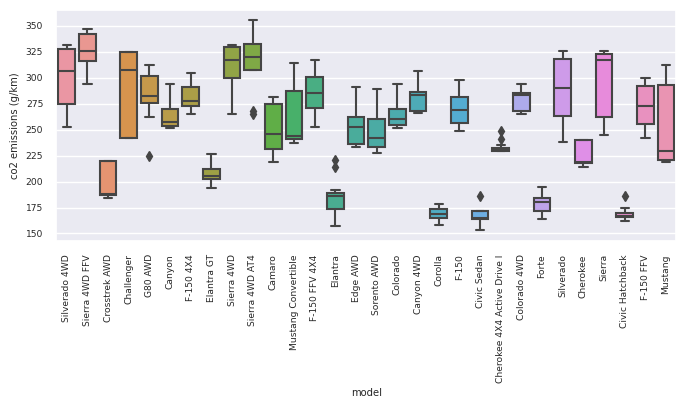

In [248]:
mask = df_train_full['model'].isin(list(df_train_full['model'].value_counts().head(30).index))
top_models = df_train_full[mask]

plt.figure(figsize=(8,3))
ax = sns.boxplot(x='model', 
                 y='co2 emissions (g/km)', 
                 data=top_models)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The distribution of CO2 emission is very different between the car models. However, the high number of unique values can make the model to overfit. Thus, this is a feature that probably will be removed from the dataset in order to train it. 

## Numerical Features
Now, let's look at the numerical features and their relations with the CO2 emission rating.

- Fuel consumption:	City and highway fuel consumption ratings are shown in litres per 100 kilometres (L/100 km) - the combined rating (55% city, 45% hwy) is shown in L/100 km and in miles per imperial gallon (mpg).

### Correlations
First, let's look at the correlations between the features.

In [23]:
num_cols

['engine size (l)',
 'fuel consumption city (l/100 km)',
 'fuel consumption hwy (l/100 km)',
 'fuel consumption comb (l/100 km)',
 'fuel consumption comb (mpg)',
 'co2 emissions (g/km)']

In [24]:
df_train_full[num_cols].corr()

,engine size (l),fuel consumption city (l/100 km),fuel consumption hwy (l/100 km),fuel consumption comb (l/100 km),fuel consumption comb (mpg),co2 emissions (g/km)
engine size (l),1.000000,0.837142,0.757712,0.822162,-0.723847,0.833662
fuel consumption city (l/100 km),0.837142,1.000000,0.933221,0.992027,-0.911873,0.949557
fuel consumption hwy (l/100 km),0.757712,0.933221,1.000000,0.970715,-0.886318,0.916930
fuel consumption comb (l/100 km),0.822162,0.992027,0.970715,1.000000,-0.917156,0.952956
fuel consumption comb (mpg),-0.723847,-0.911873,-0.886318,-0.917156,1.000000,-0.906536
co2 emissions (g/km),0.833662,0.949557,0.916930,0.952956,-0.906536,1.000000


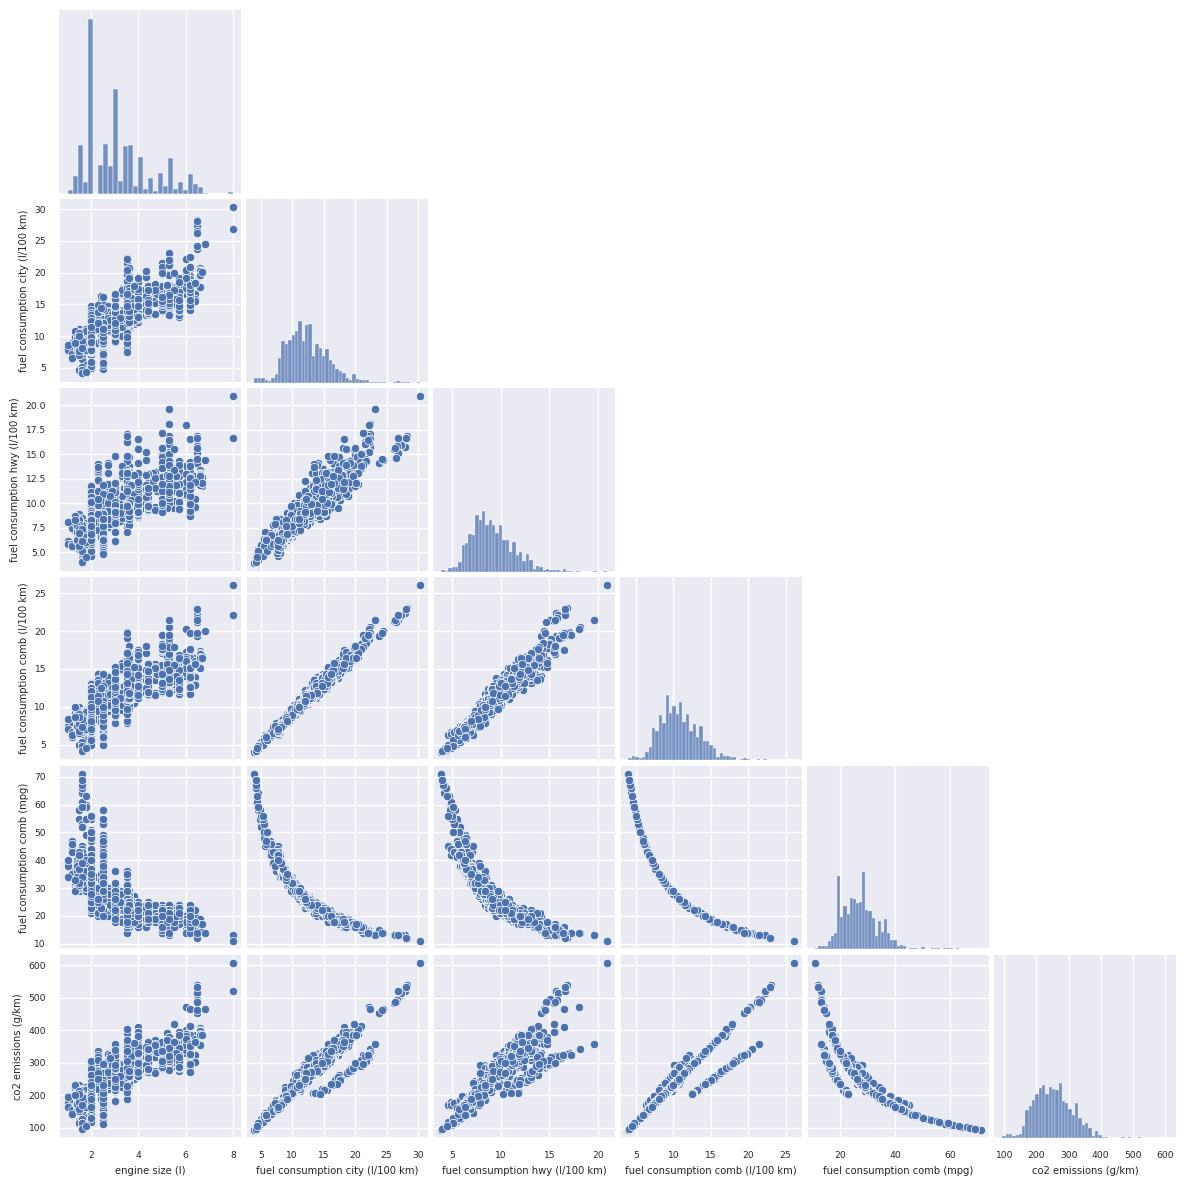

In [112]:
sns.pairplot(df_train_full[num_cols], height=2, corner=True)
sns.set(font_scale=0.6)
plt.show()

We

In [271]:
# Creating target series
y_train = df_train['co2 emissions (g/km)']
y_val = df_val['co2 emissions (g/km)']

# Removing target from train sets
# drop_cols = ['co2 emissions (g/km)']
drop_cols = ['co2 emissions (g/km)', 
             'fuel consumption city (l/100 km)', 
             'fuel consumption hwy (l/100 km)',
            #  'fuel consumption comb (l/100 km)', 
             'fuel consumption comb (mpg)', 
             'model'
            ]

X_train = df_train.drop(drop_cols, axis=1)
X_val = df_val.drop(drop_cols, axis=1)

X_cat_cols = list(X_train.loc[:, df.dtypes == object].columns)
X_num_cols = list(X_train.loc[:, df.dtypes != object].columns)

# Model Fitting
Before make some experiments, we are going to create a pipeline to help us fit the models. 

Our approach will be training a linear and a tree-based model, and compare both performances. We are going to follow these steps:
- First, we will train a Linear Regression model using just the numerical values. This will be our baseline model: everything that follows must improve the results obtained here.
- Then, we are going to use Ridge Regression as our linear model.
- Finally, we will fit a Random Forest Regressor as our ensemble model.

In [277]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def make_pipeline(model):
    """Create a pipeline for a model."""

    cat_transf = OneHotEncoder(sparse=False,
                               handle_unknown="ignore")

    std_scaler = StandardScaler()

    transformer = ColumnTransformer(transformers=[("cat", cat_transf, X_cat_cols),
                                                  ("num_scaler", std_scaler, X_num_cols)],
                                    remainder='passthrough'
                                   )

    steps = [("transformer", transformer),
             ("model", model)]
    
    return Pipeline(steps)

## Baseline Model
First, we will create a dataset containing only numerical features, and train a Linear Regression model to serve as baseline. 

In [273]:
X_train_num = df_train[num_cols].drop(['co2 emissions (g/km)'], axis=1)
X_val_num = df_val[num_cols].drop(['co2 emissions (g/km)'], axis=1)

In [170]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lrg = LinearRegression()

pipe_lrg = make_pipeline(lrg) 

pipe_lrg.fit(X_train_num, y_train)

y_pred_train = pipe_lrg.predict(X_train_num)
y_pred_val = pipe_lrg.predict(X_val_num)

lrg_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
lrg_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("RMSE Train = {:0.3f}".format(lrg_score_train))
print("RMSE Validation = {:0.3f}".format(lrg_score_val))

ValueError: A given column is not a column of the dataframe

## Ridge Regression
Now, we will train a Ridge Regression model. Let's use a list of alpha values and check which one gives the best results.

In [274]:
from sklearn.linear_model import Ridge

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
    rdg = Ridge(alpha=alpha)

    pipe_rdg = make_pipeline(rdg)

    pipe_rdg.fit(X_train, y_train)

    y_pred_train = pipe_rdg.predict(X_train)
    y_pred_val = pipe_rdg.predict(X_val)

    rdg_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rdg_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

    print("Alpha: ", alpha)
    print("RMSE Train = {:0.3f}".format(rdg_score_train))
    print("RMSE Validation = {:0.3f}".format(rdg_score_val))

Alpha:  0.001
RMSE Train = 2.869
RMSE Validation = 2.750
Alpha:  0.01
RMSE Train = 2.869
RMSE Validation = 2.751
Alpha:  0.1
RMSE Train = 2.869
RMSE Validation = 2.753
Alpha:  1
RMSE Train = 2.885
RMSE Validation = 2.790
Alpha:  10
RMSE Train = 3.803
RMSE Validation = 3.861
Alpha:  100
RMSE Train = 10.818
RMSE Validation = 10.998


The best alpha is `alpha=0.001`, with `RMSE = 2.869` on train dataset and `2.750` on the validation dataset. These are good scores, and the model is not overfitting.

### Performance on test data
Using the best alpha, we are going to train the model in the full train dataset (train + validation) and test it on our holdout test dataset.  

First, we create the full train and the test datasets:

In [275]:
y_train_full = df_train_full['co2 emissions (g/km)']
y_test = df_test['co2 emissions (g/km)']

X_train_full = df_train_full[X_cat_cols + X_num_cols]
X_test = df_test[X_cat_cols + X_num_cols]

Now, we retrain the model:

In [252]:
rdg_final = Ridge(alpha = 0.001)
pipe_rdg_final = make_pipeline(rdg_final)

pipe_rdg_final.fit(X_train_full, y_train_full)

y_pred_train_full = pipe_rdg_final.predict(X_train_full)
y_pred_test = pipe_rdg_final.predict(X_test)

rdg_score_train_full = np.sqrt(mean_squared_error(y_train_full, y_pred_train_full))
rdg_score_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("RMSE Train = {:0.3f}".format(rdg_score_train_full))
print("RMSE Test = {:0.3f}".format(rdg_score_test))

RMSE Train = 1.770
RMSE Test = 2.601


In [216]:
from sklearn.model_selection import GridSearchCV

rdg_final = Ridge(alpha = 0.001)
pipe_rdg_final = make_pipeline(rdg_final)

param_grid_rdg = {'model__alpha': alpha_list}

gs_cv_rdg = GridSearchCV(pipe_rdg_final, param_grid_rdg,
                         scoring='neg_root_mean_squared_error', cv=5)

gs_cv_rdg.fit(X_train, y_train)

y_pred_train_full = gs_cv_rdg.predict(X_train_full)
y_pred_test = gs_cv_rdg.predict(X_test)

rdg_score_train_full = np.sqrt(mean_squared_error(y_train_full, y_pred_train_full))
rdg_score_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("RMSE Train = {:0.3f}".format(rdg_score_train_full))
print("RMSE Test = {:0.3f}".format(rdg_score_test))

RMSE Train = 2.708
RMSE Test = 2.337


In [192]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor

# rfr = RandomForestRegressor(random_state=15)

# pipe_rfr_cv = make_pipeline(rfr)

# param_grid_rfr = {
#     'model__max_depth': depth_list,
#     'model__n_estimators': [10, 20, 50, 100, 300, 1000, 2000],
#     'model__min_samples_leaf': leaf_list,
# }

# rs_cv_rfr = RandomizedSearchCV(estimator = pipe_rfr_cv,
#                                param_distributions = param_grid_rfr,
#                                n_iter=30, cv=5,
#                                verbose=0, scoring='neg_root_mean_squared_error',
#                                random_state=3, n_jobs = 4)

# rs_cv_rfr.fit(X_train_full, y_train_full)

# y_pred_train_full = rs_cv_rfr.predict(X_train_full)
# y_pred_test = rs_cv_rfr.predict(X_test)

# rfr_score_train_full = np.sqrt(mean_squared_error(y_train_full, y_pred_train_full))
# rfr_score_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print("RMSE Train = {:0.3f}".format(rfr_score_train_full))
# print("RMSE Test = {:0.3f}".format(rfr_score_test))

RMSE Train = 0.777
RMSE Test = 1.475


In [220]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rfr = RandomForestRegressor()

pipe_rfr = make_pipeline(rfr)

pipe_rfr.fit(X_train, y_train)

y_pred_train = pipe_rfr.predict(X_train)
y_pred_val = pipe_rfr.predict(X_val)

rfr_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rfr_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("RMSE Train = {:0.3f}".format(rfr_score_train))
print("RMSE Validation = {:0.3f}".format(rfr_score_val))

RMSE Train = 1.337
RMSE Validation = 3.228


In [194]:
# num_trees = range(100, 301, 10)
num_trees = [10, 20, 50, 100, 300, 1000, 2000]

rmses = []
for n in num_trees:

    rfr = RandomForestRegressor(n_estimators=n, random_state=3)
    pipe_rfr = make_pipeline(rfr)

    pipe_rfr.fit(X_train, y_train)

    y_pred = pipe_rfr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('%3s -> %.3f' % (n, rmse))

    rmses.append(rmse)

 10 -> 3.022
 20 -> 3.053
 50 -> 2.816
100 -> 2.890
300 -> 2.702
1000 -> 2.681
2000 -> 2.681


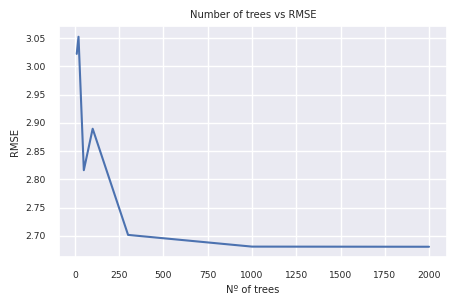

In [195]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, rmses)
plt.xlabel('Nº of trees')
plt.ylabel('RMSE')
plt.title('Number of trees vs RMSE')
plt.show()

In [196]:
all_rmses_depth = {}
depth_list = [5, 10, 20, None]

for depth in depth_list:
    print('max_depth: %s' % depth)

    rmses = []
    for trees in num_trees:
        rfr = RandomForestRegressor(n_estimators=trees, 
                                    max_depth=depth, 
                                    random_state=3)
        pipe_rfr = make_pipeline(rfr)

        pipe_rfr.fit(X_train, y_train)

        y_pred = pipe_rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%3s -> %.3f' % (trees, rmse))

        rmses.append(rmse)
    
    print()

    all_rmses_depth[depth] = rmses

max_depth: 5
 10 -> 6.988
 20 -> 7.099
 50 -> 6.909
100 -> 6.858
300 -> 6.678
1000 -> 6.624
2000 -> 6.631

max_depth: 10
 10 -> 2.929
 20 -> 2.815
 50 -> 2.726
100 -> 2.815
300 -> 2.772
1000 -> 2.760
2000 -> 2.725

max_depth: 20
 10 -> 2.840
 20 -> 2.943
 50 -> 2.751
100 -> 2.814
300 -> 2.716
1000 -> 2.695
2000 -> 2.678

max_depth: None
 10 -> 3.022
 20 -> 3.053
 50 -> 2.816
100 -> 2.890
300 -> 2.702
1000 -> 2.681
2000 -> 2.681



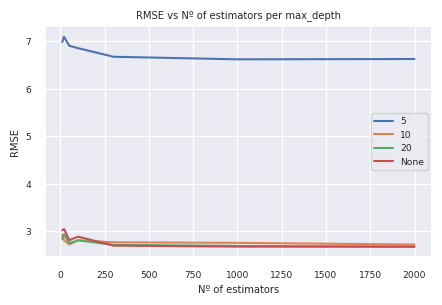

In [197]:
plt.figure(figsize=(5,3))
for depth in depth_list:
    if depth == None:
        plt.plot(num_trees, all_rmses_depth[depth], '-', label="None")
    else:
        plt.plot(num_trees, all_rmses_depth[depth], '-', label=depth)
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs Nº of estimators per max_depth')
plt.show()

In [198]:
all_rmses_leaf = {}
leaf_list = [1, 2, 3, 4]

for samples in leaf_list:
    print('min_samples_leaf: %s' % samples)

    rmses = []
    for trees in num_trees:
        rfr = RandomForestRegressor(n_estimators=trees,
                                    max_depth=20, 
                                    min_samples_leaf=samples, 
                                    random_state=3)
        pipe_rfr = make_pipeline(rfr)
        pipe_rfr.fit(X_train, y_train)

        y_pred = pipe_rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%3s -> %.3f' % (trees, rmse))

        rmses.append(rmse)
    
    print()

    all_rmses_leaf[samples] = rmses

min_samples_leaf: 1
 10 -> 2.840
 20 -> 2.943
 50 -> 2.751
100 -> 2.814
300 -> 2.716
1000 -> 2.695
2000 -> 2.678

min_samples_leaf: 2
 10 -> 3.471
 20 -> 3.499
 50 -> 3.391
100 -> 3.427
300 -> 3.291
1000 -> 3.311
2000 -> 3.335

min_samples_leaf: 3
 10 -> 4.041
 20 -> 3.980
 50 -> 3.770
100 -> 3.881
300 -> 3.787
1000 -> 3.840
2000 -> 3.868

min_samples_leaf: 4
 10 -> 4.311
 20 -> 4.374
 50 -> 4.281
100 -> 4.339
300 -> 4.193
1000 -> 4.227
2000 -> 4.246



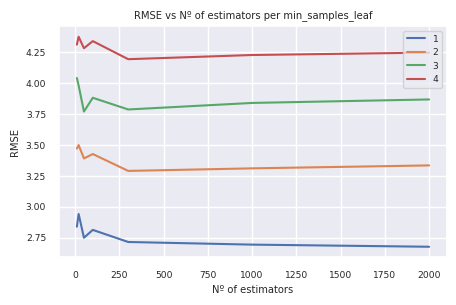

In [200]:
plt.figure(figsize=(5,3))
for leaf in leaf_list:
    plt.plot(num_trees, all_rmses_leaf[leaf], '-', label=leaf)
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs Nº of estimators per min_samples_leaf')
plt.show()

In [290]:
rfr_final = RandomForestRegressor(n_estimators=2000, 
                                  max_depth=20, 
                                  min_samples_leaf=1,
                                  random_state=3)
pipe_rfr_final = make_pipeline(rfr_final)

pipe_rfr_final.fit(X_train, y_train)

y_pred_train = pipe_rfr_final.predict(X_train)
y_pred_val = pipe_rfr_final.predict(X_val)

rfr_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rfr_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("ROC AUC Train = {:0.3f}".format(rfr_score_train))
print("ROC AUC Validation = {:0.3f}".format(rfr_score_val))

ROC AUC Train = 1.131
ROC AUC Validation = 2.678


### Test Data

In [292]:
rfr_final = RandomForestRegressor(n_estimators=150, 
                                #   max_depth=20, 
                                #   min_samples_leaf=1,
                                  random_state=3)
pipe_rfr_final = make_pipeline(rfr_final)

pipe_rfr_final.fit(X_train_full, y_train_full)

y_pred_train_full = pipe_rfr_final.predict(X_train_full)
y_pred_test = pipe_rfr_final.predict(X_test)

rfr_score_train_full = np.sqrt(mean_squared_error(y_train_full, y_pred_train_full))
rfr_score_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("RMSE Train = {:0.3f}".format(rfr_score_train_full))
print("RMSE Test = {:0.3f}".format(rfr_score_test))

RMSE Train = 0.846
RMSE Test = 1.474


In [269]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=100, random_state=5)

pipe_xgb = make_pipeline(model_xgb)

pipe_xgb.fit(X_train_full, y_train_full)

pred_train_full_xgb = pipe_xgb.predict(X_train_full)
pred_test_xgb = pipe_xgb.predict(X_test)

xgb_score_train_full = np.sqrt(mean_squared_error(y_train_full, pred_train_full_xgb))
xgb_score_test = np.sqrt(mean_squared_error(y_test, pred_test_xgb))

print("RMSE Train = {:0.3f}".format(xgb_score_train_full))
print("RMSE Test = {:0.3f}".format(xgb_score_test))

RMSE Train = 0.823
RMSE Test = 1.402


In [287]:
# num_trees = range(100, 301, 10)
num_trees = [10, 20, 50, 100, 200]

rmses = []
for n in num_trees:

    model_xgb = XGBRegressor(n_estimators=n, random_state=5)

    pipe_xgb = make_pipeline(model_xgb)

    pipe_xgb.fit(X_train, y_train)

    y_pred = pipe_xgb.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('%3s -> %.3f' % (n, rmse))

    rmses.append(rmse)

 10 -> 8.479
 20 -> 2.305
 50 -> 1.999
100 -> 1.859
200 -> 1.803


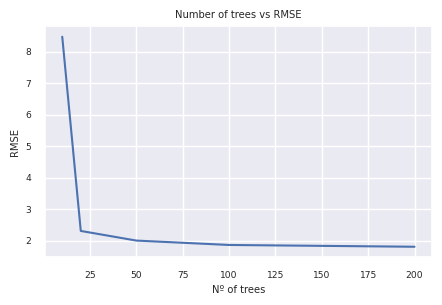

In [288]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, rmses)
plt.xlabel('Nº of trees')
plt.ylabel('RMSE')
plt.title('Number of trees vs RMSE')
plt.show()

In [278]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=2000, random_state=5)

pipe_xgb = make_pipeline(model_xgb)

pipe_xgb.fit(X_train_full, y_train_full)

pred_train_full_xgb = pipe_xgb.predict(X_train_full)
pred_test_xgb = pipe_xgb.predict(X_test)

xgb_score_train_full = np.sqrt(mean_squared_error(y_train_full, pred_train_full_xgb))
xgb_score_test = np.sqrt(mean_squared_error(y_test, pred_test_xgb))

print("RMSE Train = {:0.3f}".format(xgb_score_train_full))
print("RMSE Test = {:0.3f}".format(xgb_score_test))

KeyboardInterrupt: 

In [245]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

model_xgb = XGBRegressor(random_state=5)

pipe_xgb = make_pipeline(model_xgb)

param_grid_xgb = {
    'model__max_depth': [3, 5, 7, 9, 11],
    'model__n_estimators': [10, 20, 50, 100, 300, 1000, 2000],
    'model__eta':  [0.1, 0.2, 0.3, 0.4, 0.5],
}

rs_cv_xgb = RandomizedSearchCV(estimator = pipe_xgb,
                               param_distributions = param_grid_xgb,
                               n_iter=30, cv=5,
                               verbose=0, scoring='neg_root_mean_squared_error',
                               random_state=3, n_jobs = 4)

rs_cv_xgb.fit(X_train_full, y_train_full)

pred_train_full_xgb = rs_cv_xgb.predict(X_train_full)
pred_test_xgb = rs_cv_xgb.predict(X_test)

xgb_score_train_full = np.sqrt(mean_squared_error(y_train_full, pred_train_full_xgb))
xgb_score_test = np.sqrt(mean_squared_error(y_test, pred_test_xgb))

print("RMSE Train = {:0.3f}".format(xgb_score_train_full))
print("RMSE Test = {:0.3f}".format(xgb_score_test))

RMSE Train = 0.842
RMSE Test = 1.333


# Conclusion

The best model is XGBoost Regressor!